<a href="https://colab.research.google.com/github/JoshEthan/Prove06/blob/master/Semester_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Joshua Rolph.

I chose a dataset with lots of images. I hoped to be able to use a CNN to create new images from the dataset images.
The images were fitted and sized and put into training and test sets.*italicized text*
I followed along someones tutorial and was able to get good results. Although it took a long time and even more time for all the data to be processed. I then wanted to try it on my own dataset. This one is still not done. It needs to parameters to be tweaked some more. Honestly not even sure if any results will come from it. 
I learned a good deal about creating a CNN. I know I'll learn even more the weeks to come.

# Get File

In [1]:
!unzip "/content/drive/My Drive/Data/Pokemon.zip"

Archive:  /content/drive/My Drive/Data/Pokemon.zip
  inflating: images/images/abomasnow.png  
  inflating: images/images/abra.png  
  inflating: images/images/absol.png  
  inflating: images/images/accelgor.png  
  inflating: images/images/aegislash-blade.png  
  inflating: images/images/aerodactyl.png  
  inflating: images/images/aggron.png  
  inflating: images/images/aipom.png  
  inflating: images/images/alakazam.png  
  inflating: images/images/alomomola.png  
  inflating: images/images/altaria.png  
  inflating: images/images/amaura.png  
  inflating: images/images/ambipom.png  
  inflating: images/images/amoonguss.png  
  inflating: images/images/ampharos.png  
  inflating: images/images/anorith.png  
  inflating: images/images/araquanid.jpg  
  inflating: images/images/arbok.png  
  inflating: images/images/arcanine.png  
  inflating: images/images/arceus.png  
  inflating: images/images/archen.png  
  inflating: images/images/archeops.png  
  inflating: images/images/ariados.p

#Import Libraries

In [2]:
# IMPORT LIBRARIES
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
seed = 6060

# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  6060


#Define Variables

In [13]:
# DEFINE VARIABLES

# Root directory for dataset
from google.colab import drive
dataroot = "/content/Data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#Create Dataset

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


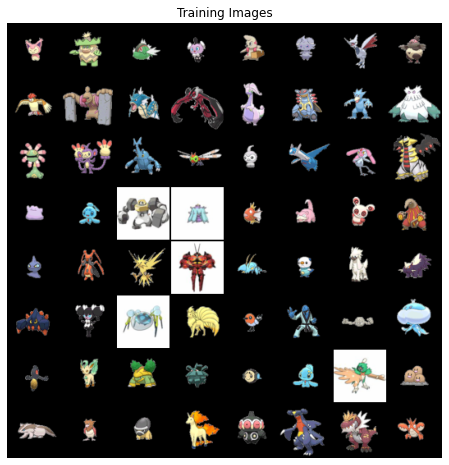

In [14]:
#CREATE DATASET

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


#DCGAN Implement

In [15]:
# DCGAN IMPLEMENTATION

##Initialize weights##
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

##Generator##
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

        # Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

##Discriminator##
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#Training

In [16]:
#TRAINING
##Loss functions and Optimizers##
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

##Begin training##
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

counterA = 1        
counterB = 1

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    print("Counter A: ", counterA)
    counterA += 1
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        print("Counter B: ", counterB)
        counterB += 1

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
Counter A:  1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  1
[0/50][0/7]	Loss_D: 2.1520	Loss_G: 5.0382	D(x): 0.5861	D(G(z)): 0.7341 / 0.0119
Counter B:  2
Counter B:  3
Counter B:  4
Counter B:  5
Counter B:  6
Counter B:  7
Counter A:  2


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  8
[1/50][0/7]	Loss_D: 0.1042	Loss_G: 7.2315	D(x): 0.9575	D(G(z)): 0.0514 / 0.0012
Counter B:  9
Counter B:  10
Counter B:  11
Counter B:  12
Counter B:  13
Counter B:  14
Counter A:  3


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  15
[2/50][0/7]	Loss_D: 0.0892	Loss_G: 8.2517	D(x): 0.9761	D(G(z)): 0.0573 / 0.0004
Counter B:  16
Counter B:  17
Counter B:  18
Counter B:  19
Counter B:  20
Counter B:  21
Counter A:  4


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  22
[3/50][0/7]	Loss_D: 0.0176	Loss_G: 9.4335	D(x): 0.9841	D(G(z)): 0.0003 / 0.0001
Counter B:  23
Counter B:  24
Counter B:  25
Counter B:  26
Counter B:  27
Counter B:  28
Counter A:  5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  29
[4/50][0/7]	Loss_D: 0.4756	Loss_G: 23.2676	D(x): 0.9820	D(G(z)): 0.3406 / 0.0000
Counter B:  30
Counter B:  31
Counter B:  32
Counter B:  33
Counter B:  34
Counter B:  35
Counter A:  6


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  36
[5/50][0/7]	Loss_D: 0.0004	Loss_G: 28.5623	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
Counter B:  37
Counter B:  38
Counter B:  39
Counter B:  40
Counter B:  41
Counter B:  42
Counter A:  7


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  43
[6/50][0/7]	Loss_D: 2.6488	Loss_G: 15.9181	D(x): 0.2865	D(G(z)): 0.0000 / 0.0000
Counter B:  44
Counter B:  45
Counter B:  46
Counter B:  47
Counter B:  48
Counter B:  49
Counter A:  8


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  50
[7/50][0/7]	Loss_D: 2.2438	Loss_G: 21.3464	D(x): 0.9903	D(G(z)): 0.6804 / 0.0000
Counter B:  51
Counter B:  52
Counter B:  53
Counter B:  54
Counter B:  55
Counter B:  56
Counter A:  9


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  57
[8/50][0/7]	Loss_D: 0.5810	Loss_G: 19.0957	D(x): 0.7267	D(G(z)): 0.0000 / 0.0000
Counter B:  58
Counter B:  59
Counter B:  60
Counter B:  61
Counter B:  62
Counter B:  63
Counter A:  10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  64
[9/50][0/7]	Loss_D: 0.0250	Loss_G: 6.1154	D(x): 0.9890	D(G(z)): 0.0111 / 0.0063
Counter B:  65
Counter B:  66
Counter B:  67
Counter B:  68
Counter B:  69
Counter B:  70
Counter A:  11


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  71
[10/50][0/7]	Loss_D: 0.6654	Loss_G: 18.4669	D(x): 0.9932	D(G(z)): 0.4216 / 0.0000
Counter B:  72
Counter B:  73
Counter B:  74
Counter B:  75
Counter B:  76
Counter B:  77
Counter A:  12


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  78
[11/50][0/7]	Loss_D: 0.2907	Loss_G: 23.7420	D(x): 0.8353	D(G(z)): 0.0000 / 0.0000
Counter B:  79
Counter B:  80
Counter B:  81
Counter B:  82
Counter B:  83
Counter B:  84
Counter A:  13


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  85
[12/50][0/7]	Loss_D: 0.0525	Loss_G: 7.5108	D(x): 0.9676	D(G(z)): 0.0026 / 0.0017
Counter B:  86
Counter B:  87
Counter B:  88
Counter B:  89
Counter B:  90
Counter B:  91
Counter A:  14


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  92
[13/50][0/7]	Loss_D: 0.1248	Loss_G: 7.2706	D(x): 0.9742	D(G(z)): 0.0811 / 0.0035
Counter B:  93
Counter B:  94
Counter B:  95
Counter B:  96
Counter B:  97
Counter B:  98
Counter A:  15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  99
[14/50][0/7]	Loss_D: 0.9068	Loss_G: 12.1043	D(x): 0.9890	D(G(z)): 0.4444 / 0.0000
Counter B:  100
Counter B:  101
Counter B:  102
Counter B:  103
Counter B:  104
Counter B:  105
Counter A:  16


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  106
[15/50][0/7]	Loss_D: 1.2547	Loss_G: 9.7917	D(x): 0.9932	D(G(z)): 0.4767 / 0.0001
Counter B:  107
Counter B:  108
Counter B:  109
Counter B:  110
Counter B:  111
Counter B:  112
Counter A:  17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  113
[16/50][0/7]	Loss_D: 0.2528	Loss_G: 5.0946	D(x): 0.8422	D(G(z)): 0.0160 / 0.0170
Counter B:  114
Counter B:  115
Counter B:  116
Counter B:  117
Counter B:  118
Counter B:  119
Counter A:  18


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  120
[17/50][0/7]	Loss_D: 0.2757	Loss_G: 5.0831	D(x): 0.9918	D(G(z)): 0.2185 / 0.0093
Counter B:  121
Counter B:  122
Counter B:  123
Counter B:  124
Counter B:  125
Counter B:  126
Counter A:  19


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  127
[18/50][0/7]	Loss_D: 0.1120	Loss_G: 4.0702	D(x): 0.9328	D(G(z)): 0.0348 / 0.0295
Counter B:  128
Counter B:  129
Counter B:  130
Counter B:  131
Counter B:  132
Counter B:  133
Counter A:  20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  134
[19/50][0/7]	Loss_D: 0.6647	Loss_G: 3.7421	D(x): 0.6565	D(G(z)): 0.0157 / 0.1058
Counter B:  135
Counter B:  136
Counter B:  137
Counter B:  138
Counter B:  139
Counter B:  140
Counter A:  21


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  141
[20/50][0/7]	Loss_D: 0.1529	Loss_G: 4.8323	D(x): 0.9055	D(G(z)): 0.0298 / 0.0132
Counter B:  142
Counter B:  143
Counter B:  144
Counter B:  145
Counter B:  146
Counter B:  147
Counter A:  22


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  148
[21/50][0/7]	Loss_D: 0.1500	Loss_G: 3.8082	D(x): 0.9111	D(G(z)): 0.0386 / 0.0347
Counter B:  149
Counter B:  150
Counter B:  151
Counter B:  152
Counter B:  153
Counter B:  154
Counter A:  23


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  155
[22/50][0/7]	Loss_D: 0.8197	Loss_G: 6.8866	D(x): 0.9931	D(G(z)): 0.4856 / 0.0045
Counter B:  156
Counter B:  157
Counter B:  158
Counter B:  159
Counter B:  160
Counter B:  161
Counter A:  24


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  162
[23/50][0/7]	Loss_D: 0.0886	Loss_G: 4.3565	D(x): 0.9802	D(G(z)): 0.0645 / 0.0180
Counter B:  163
Counter B:  164
Counter B:  165
Counter B:  166
Counter B:  167
Counter B:  168
Counter A:  25


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  169
[24/50][0/7]	Loss_D: 0.2082	Loss_G: 5.0809	D(x): 0.9918	D(G(z)): 0.1657 / 0.0116
Counter B:  170
Counter B:  171
Counter B:  172
Counter B:  173
Counter B:  174
Counter B:  175
Counter A:  26


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  176
[25/50][0/7]	Loss_D: 0.3724	Loss_G: 2.5366	D(x): 0.7490	D(G(z)): 0.0120 / 0.1448
Counter B:  177
Counter B:  178
Counter B:  179
Counter B:  180
Counter B:  181
Counter B:  182
Counter A:  27


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  183
[26/50][0/7]	Loss_D: 0.5002	Loss_G: 6.7723	D(x): 0.9980	D(G(z)): 0.3489 / 0.0022
Counter B:  184
Counter B:  185
Counter B:  186
Counter B:  187
Counter B:  188
Counter B:  189
Counter A:  28


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  190
[27/50][0/7]	Loss_D: 0.1734	Loss_G: 3.7814	D(x): 0.8684	D(G(z)): 0.0090 / 0.0403
Counter B:  191
Counter B:  192
Counter B:  193
Counter B:  194
Counter B:  195
Counter B:  196
Counter A:  29


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  197
[28/50][0/7]	Loss_D: 0.0967	Loss_G: 4.7090	D(x): 0.9762	D(G(z)): 0.0682 / 0.0126
Counter B:  198
Counter B:  199
Counter B:  200
Counter B:  201
Counter B:  202
Counter B:  203
Counter A:  30


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  204
[29/50][0/7]	Loss_D: 0.4001	Loss_G: 2.3914	D(x): 0.7273	D(G(z)): 0.0103 / 0.2332
Counter B:  205
Counter B:  206
Counter B:  207
Counter B:  208
Counter B:  209
Counter B:  210
Counter A:  31


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  211
[30/50][0/7]	Loss_D: 0.0479	Loss_G: 7.0052	D(x): 0.9624	D(G(z)): 0.0072 / 0.0023
Counter B:  212
Counter B:  213
Counter B:  214
Counter B:  215
Counter B:  216
Counter B:  217
Counter A:  32


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  218
[31/50][0/7]	Loss_D: 0.0355	Loss_G: 4.9331	D(x): 0.9874	D(G(z)): 0.0218 / 0.0118
Counter B:  219
Counter B:  220
Counter B:  221
Counter B:  222
Counter B:  223
Counter B:  224
Counter A:  33


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  225
[32/50][0/7]	Loss_D: 0.0916	Loss_G: 4.8577	D(x): 0.9956	D(G(z)): 0.0815 / 0.0124
Counter B:  226
Counter B:  227
Counter B:  228
Counter B:  229
Counter B:  230
Counter B:  231
Counter A:  34


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  232
[33/50][0/7]	Loss_D: 0.0835	Loss_G: 5.5126	D(x): 0.9795	D(G(z)): 0.0577 / 0.0084
Counter B:  233
Counter B:  234
Counter B:  235
Counter B:  236
Counter B:  237
Counter B:  238
Counter A:  35


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  239
[34/50][0/7]	Loss_D: 0.0634	Loss_G: 6.2980	D(x): 0.9499	D(G(z)): 0.0077 / 0.0036
Counter B:  240
Counter B:  241
Counter B:  242
Counter B:  243
Counter B:  244
Counter B:  245
Counter A:  36


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  246
[35/50][0/7]	Loss_D: 0.2894	Loss_G: 1.5027	D(x): 0.7858	D(G(z)): 0.0081 / 0.3470
Counter B:  247
Counter B:  248
Counter B:  249
Counter B:  250
Counter B:  251
Counter B:  252
Counter A:  37


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  253
[36/50][0/7]	Loss_D: 0.3326	Loss_G: 4.0702	D(x): 0.9056	D(G(z)): 0.1665 / 0.1082
Counter B:  254
Counter B:  255
Counter B:  256
Counter B:  257
Counter B:  258
Counter B:  259
Counter A:  38


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  260
[37/50][0/7]	Loss_D: 0.8616	Loss_G: 3.7212	D(x): 0.7793	D(G(z)): 0.1343 / 0.0680
Counter B:  261
Counter B:  262
Counter B:  263
Counter B:  264
Counter B:  265
Counter B:  266
Counter A:  39


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  267
[38/50][0/7]	Loss_D: 0.7258	Loss_G: 0.9654	D(x): 0.6352	D(G(z)): 0.0652 / 0.5513
Counter B:  268
Counter B:  269
Counter B:  270
Counter B:  271
Counter B:  272
Counter B:  273
Counter A:  40


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  274
[39/50][0/7]	Loss_D: 0.1649	Loss_G: 3.8728	D(x): 0.8813	D(G(z)): 0.0253 / 0.0316
Counter B:  275
Counter B:  276
Counter B:  277
Counter B:  278
Counter B:  279
Counter B:  280
Counter A:  41


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  281
[40/50][0/7]	Loss_D: 0.2968	Loss_G: 4.2627	D(x): 0.8912	D(G(z)): 0.1033 / 0.0244
Counter B:  282
Counter B:  283
Counter B:  284
Counter B:  285
Counter B:  286
Counter B:  287
Counter A:  42


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  288
[41/50][0/7]	Loss_D: 0.2436	Loss_G: 3.2156	D(x): 0.8911	D(G(z)): 0.1053 / 0.0700
Counter B:  289
Counter B:  290
Counter B:  291
Counter B:  292
Counter B:  293
Counter B:  294
Counter A:  43


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  295
[42/50][0/7]	Loss_D: 0.2878	Loss_G: 3.4678	D(x): 0.8564	D(G(z)): 0.0922 / 0.0454
Counter B:  296
Counter B:  297
Counter B:  298
Counter B:  299
Counter B:  300
Counter B:  301
Counter A:  44


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  302
[43/50][0/7]	Loss_D: 0.1988	Loss_G: 2.4190	D(x): 0.8703	D(G(z)): 0.0501 / 0.1320
Counter B:  303
Counter B:  304
Counter B:  305
Counter B:  306
Counter B:  307
Counter B:  308
Counter A:  45


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  309
[44/50][0/7]	Loss_D: 1.9265	Loss_G: 5.9843	D(x): 0.9991	D(G(z)): 0.7674 / 0.0079
Counter B:  310
Counter B:  311
Counter B:  312
Counter B:  313
Counter B:  314
Counter B:  315
Counter A:  46


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  316
[45/50][0/7]	Loss_D: 0.6723	Loss_G: 5.8092	D(x): 0.9938	D(G(z)): 0.4406 / 0.0059
Counter B:  317
Counter B:  318
Counter B:  319
Counter B:  320
Counter B:  321
Counter B:  322
Counter A:  47


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  323
[46/50][0/7]	Loss_D: 0.2053	Loss_G: 5.3381	D(x): 0.9738	D(G(z)): 0.1568 / 0.0069
Counter B:  324
Counter B:  325
Counter B:  326
Counter B:  327
Counter B:  328
Counter B:  329
Counter A:  48


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  330
[47/50][0/7]	Loss_D: 1.2128	Loss_G: 3.8029	D(x): 0.9111	D(G(z)): 0.5048 / 0.0369
Counter B:  331
Counter B:  332
Counter B:  333
Counter B:  334
Counter B:  335
Counter B:  336
Counter A:  49


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  337
[48/50][0/7]	Loss_D: 0.1510	Loss_G: 4.3756	D(x): 0.8881	D(G(z)): 0.0258 / 0.0183
Counter B:  338
Counter B:  339
Counter B:  340
Counter B:  341
Counter B:  342
Counter B:  343
Counter A:  50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Counter B:  344
[49/50][0/7]	Loss_D: 3.6415	Loss_G: 5.0773	D(x): 0.9975	D(G(z)): 0.8415 / 0.0434
Counter B:  345
Counter B:  346
Counter B:  347
Counter B:  348
Counter B:  349
Counter B:  350


#Results

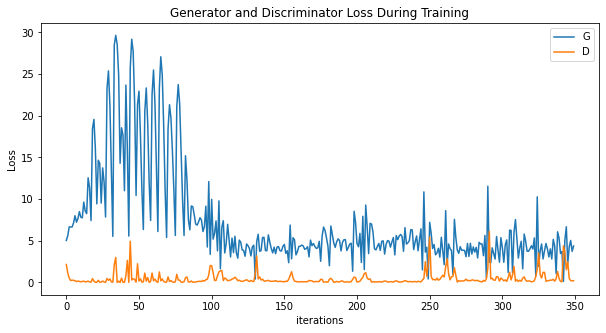

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


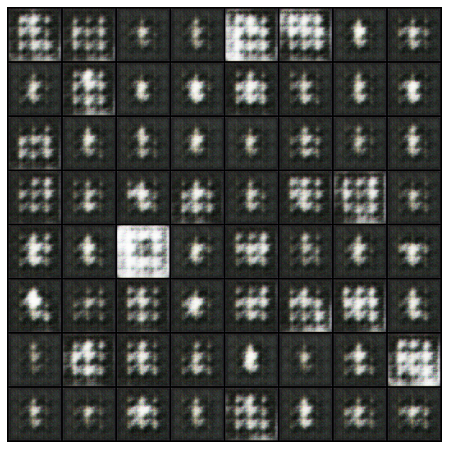

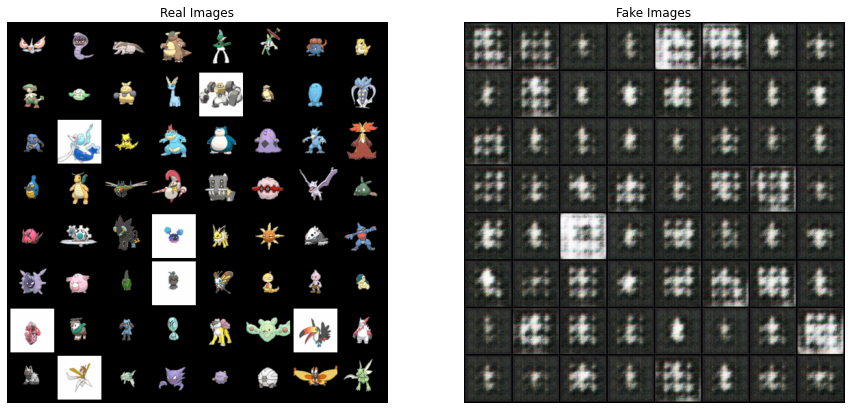

In [17]:
#RESULTS
##Loss plot##
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
##Training process##
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

#FINAL RESULTS
#Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()